מגישה באיחור של שמונה ימים משתמשת בימים 7-15
## Maman 15
Youtube: 

Questions 1 & 2  - https://www.youtube.com/watch?v=6uldT402mr4

Question 3 - https://www.youtube.com/watch?v=nffyEVtUWxs

# Question 1
Implement Conv2d with padding and stride.

In [1]:
''' Libraries '''

import torch
from torch import nn

In [2]:
''' ManualConv2d layer '''

class ManualConv2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, kernel_size=(1,1), stride=1, padding=0):
        super().__init__()
        # Each output channel has its own kernel and bias.
        # Each kernel is 3d 'in_channels x p x q' in size.
        self.kern = nn.Parameter(torch.rand((out_channels, in_channels,*kernel_size)))
        self.bias = nn.Parameter(torch.rand((out_channels,1)))
        
        self.in_channels, self.out_channels = in_channels, out_channels
        self.p , self.q  = kernel_size
        self.stride, self.padding = stride, padding


    def _pad_img(self, img):
        # Pad the inputs.
        nB, nC, nH, nW = img.shape # Calculate the new shape.
        nPad = self.padding
        shape_new = (nB, nC, nH + 2*nPad, nW + 2*nPad)

        pad_img = torch.zeros(shape_new) # insert the input into the right place) 
        pad_img[..., nPad:nPad + nH, nPad:nPad + nW] = img

        return pad_img


    def forward(self, X):
        # Calculating new shape: first pad, then care to stop at the point 
        # where kernel does not run out of image and then stride:
        get_output_size = lambda input_size, kern_size: \
            int((input_size + 2 * self.padding - kern_size) / self.stride) + 1
        
        nB, nC, nH, nW = X.shape
        # Create the output template of the desired shape (without values).
        output = torch.empty(nB, self.out_channels,
                             get_output_size(nH, self.p),
                             get_output_size(nW, self.q))
        # Pad the inputs.
        X_pad = self._pad_img(X)
        
        nB, nC, nH_out, nW_out = output.shape 
        # Calculate and insert the output values ​​into the output template.
        nS = self.stride
        for i in range(nH_out):
            iS = i*nS
            for j in range(nW_out):
                jS =  j*nS
                sub_img = X_pad[..., iS:(iS + self.p), jS:(jS + self.q)] # jump according to striding
                #print(sub_img.shape, self.kern.shape)
                sub_img = sub_img.unsqueeze(1) # output chan. dim 
                #correl =  sub_img*self.kern
                #print(correl.shape)
                output[...,i,j] = (sub_img*self.kern).sum(dim=(2,3,4))
        
        # Each channel has its own bias. So reshape bias to fit the channels.
        return output + self.bias.reshape(1,-1,1,1)

In [3]:
''' Comparison between manually written layer and PyTorch layer '''

# Variables
batch_size = 2
H, W = 6,6

in_channels = 3
out_channels = 4

kernel_size = (2,2)
stride = 2
padding = 1

# Random sample
X = torch.rand(batch_size, in_channels, H, W)

# PyTorch layer
py_conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                kernel_size=kernel_size, stride=stride, padding=padding)
# Our layer
man_conv = ManualConv2d(in_channels=in_channels, out_channels=out_channels,
                    kernel_size=kernel_size, stride=stride, padding=padding)

# Replace man_conv parameters to coincide with py_conv parameters.
man_conv.kern = torch.nn.Parameter(py_conv._parameters['weight'], requires_grad=False)
man_conv.bias = torch.nn.Parameter(py_conv._parameters['bias'], requires_grad=False)

# Results
py_out  = py_conv.forward(X)
man_out = man_conv.forward(X)

# The results will not be exactly equal due to numerical errors.
# compare the results with 6 digits accuracy after zero.
print("The answer is:", (abs(man_out - py_out) < 1e-6).all())
print("\nPyTorch results:", py_out.detach(), sep='\n')
print("\nOur results:", man_out, sep='\n')

The answer is: tensor(True)

PyTorch results:
tensor([[[[-0.4079, -0.2090, -0.3876, -0.2298],
          [-0.2748, -0.1384, -0.2149, -0.1164],
          [-0.2344, -0.2839, -0.2902, -0.1683],
          [-0.1886, -0.2685, -0.2339, -0.3582]],

         [[-0.0937, -0.1884, -0.2234, -0.1618],
          [-0.5684,  0.0008,  0.0102, -0.0579],
          [-0.3170, -0.2745, -0.2781, -0.1742],
          [-0.2351, -0.2336, -0.1958, -0.2224]],

         [[-0.0465, -0.4031, -0.1982, -0.2962],
          [-0.1202,  0.0360,  0.0514, -0.0491],
          [-0.1553,  0.2274, -0.0963, -0.2496],
          [-0.0404, -0.0106,  0.0305,  0.0753]],

         [[-0.0197,  0.2402,  0.3065,  0.1967],
          [ 0.0501,  0.2280,  0.2997, -0.0258],
          [-0.0574,  0.1257,  0.2960,  0.0272],
          [-0.1140, -0.0830, -0.0334, -0.1970]]],


        [[[-0.5063, -0.1353, -0.3124, -0.0583],
          [-0.3656, -0.1943, -0.1551, -0.0326],
          [-0.3265, -0.2764, -0.3653, -0.0859],
          [-0.2286, -0.3569, -0.

# Question 2: Calculate the derivative of C by the kernel and by the input.

# Question 3
Transfer learning (ResNet).

In [4]:
''' Libraries required '''
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

''' Debug when errors occur '''
from pdb import set_trace as pst
from pdb import pm

## Sections 1, 2 ,3

In [5]:
'''  Load the CIFAR-10 dataset '''

transform = transforms.Compose(
            [transforms.PILToTensor(),
            transforms.ConvertImageDtype(torch.float)])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:05<00:00, 29256839.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


1 plane


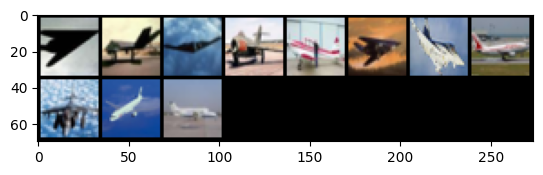


2 car


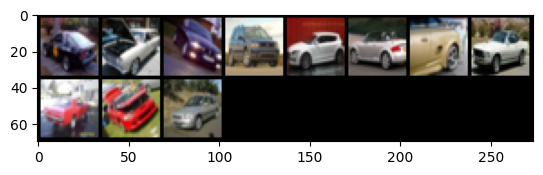


3 bird


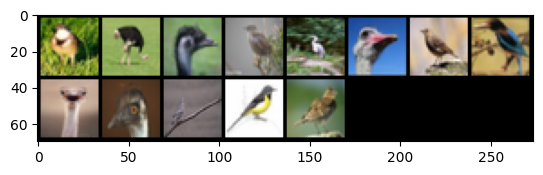


4 cat


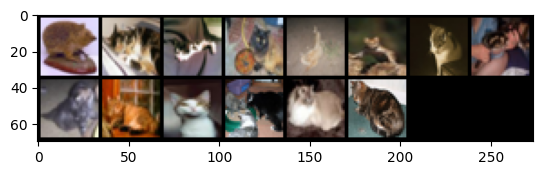


5 deer


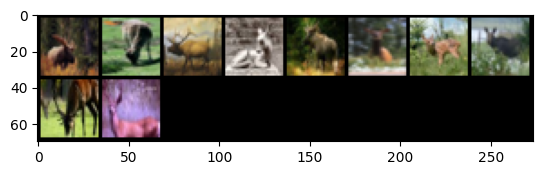


6 dog


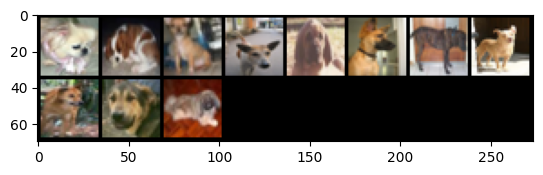


7 frog


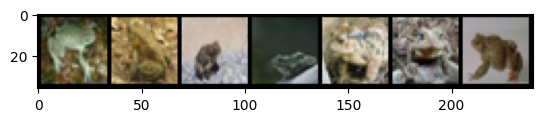


8 horse


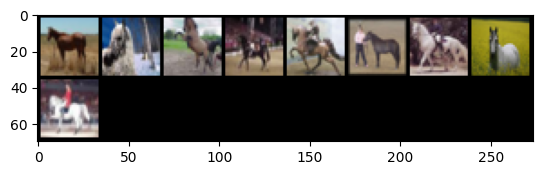


9 ship


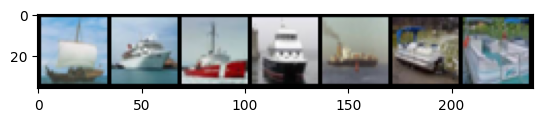


10 truck


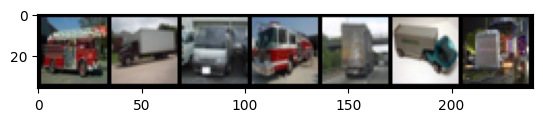

In [6]:
''' Print several samples from each class. '''

# Data loader for training set
batch_size = 100
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter) #dataiter.next()
#images, labels = trainloader.next()

# print labels and show images
for i in range(10):
    print(i+1, classes[i])
    # Choose from the batch only the indexes of the images from class i.
    idx = (labels == i).nonzero()
    # Make a grid of images from the same class (and convert to numpy).
    npimg = torchvision.utils.make_grid(images[idx.flatten()]).numpy()
    # Move color channel dim to the end, and display the data as an image.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show() # Print the images.
    print()

## Sections 4, 5 ,6, 7

In [7]:
''' Run on GPU (if possible). '''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

''' Load ResNet-18 '''
resnet18 = models.resnet18(pretrained=True)

''' Set the parameters to not require gradients. '''
for param in resnet18.parameters():
    param.requires_grad = False
    

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 256MB/s]


In [8]:
# named_modules an iterator over all modules in the network, yielding both the name of the module as well as the module itself.
for idx, m in enumerate(resnet18.named_modules()):
  print(idx, '->', m)

0 -> ('', ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

In [9]:
''' Reshape ResNet. '''
# The number of classes of CIFAR-10.
num_classes = len(classes)
# Print the name and properties of ResNet last layer (the classifier header).
for m in resnet18.named_modules(): pass
print("The name of the last layer: ", m[0])
print("last-layer: ", m[1])

# Replace the classifier with the classifier that matches to CIFAR-10.
resnet18.fc = nn.Linear(512, num_classes)
print("New last-layer: ", resnet18.fc)

# Run the net on GPU
_ = resnet18.to(device)

The name of the last layer:  fc
last-layer:  Linear(in_features=512, out_features=1000, bias=True)
New last-layer:  Linear(in_features=512, out_features=10, bias=True)


In [10]:
''' Data preprocessing before training '''

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# this leads to better results, probably background matters:
transform = transforms.Compose([transforms.Resize(224), 
                                transforms.ToTensor(),
                                normalize])

# Make transform before training/testing:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Data loaders for training and test sets.
train_minibatch = 512
# Adjust the test batch to train batch, so the model will run the
# same order of batches in training and test sets, at each epoch.
test_minibatch = train_minibatch // (len(trainset)//len(testset))

trainloader = DataLoader(trainset, batch_size=train_minibatch, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=test_minibatch, shuffle=True, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
''' train and test functions '''

def train_epoch(model, trainloader, optimizer, loss):
    trainloss, trainacc = [], [] # Save the results for each batch
    
    for X, y in tqdm(trainloader):
        X = X.float().to(device) # Samples
        y = y.to(device) # Results
        # Make each result to one hot vector (for Cross Entropy Loss).
        y_hot = nn.functional.one_hot(y, num_classes=num_classes).float()

        optimizer.zero_grad()
        y_model = model(X) # Model evaluation
        loss = CE_loss(y_model,y_hot) # Loss
        trainloss.append(loss.cpu().detach()) # Add this loss to its list.
        
        # In each sample, select the class the model is most confident.
        predicted_y = y_model.argmax(dim=1)
        acc = (predicted_y == y).sum()/len(y) # Accuracy
        trainacc.append(acc.cpu().detach()) # Add this acc to its list.
        
        loss.backward()
        optimizer.step()

    return trainloss, trainacc

def test(model, testloader, loss):
    testloss, testacc = [], [] # Save the results for each batch

    for X, y in tqdm(testloader):
        X = X.float().to(device) # Samples
        y = y.to(device) # Results
        # Make each result to one hot vector (for Cross Entropy Loss).
        y_hot = nn.functional.one_hot(y, num_classes=num_classes).float()

        with torch.no_grad():
            y_model = model(X) # Model evaluation
            loss = CE_loss(y_model,y_hot) # Loss
        testloss.append(loss.cpu().detach()) # Add this loss to its list.
        
        # In each sample, select the class the model is most confident.
        predicted_y = y_model.argmax(dim=1)
        acc = (predicted_y == y).sum()/len(y) # Accuracy
        testacc.append(acc.cpu().detach()) # Add this acc to its list.

    return testloss, testacc

In [12]:
''' Set loss function and optimizer. '''
CE_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.1)

''' Train and test the model. '''
EPOCHS = 2
trainloss, trainacc, testloss, testacc = [], [], [], []
for i in range(EPOCHS):
    print(f"Epoch {i+1} train:")
    tr_l, tr_a = train_epoch(resnet18, trainloader, optimizer, CE_loss)
    trainloss.extend(tr_l), trainacc.extend(tr_a)
EPOCHS = 1
for i in range(EPOCHS):
    print(f"Epoch {i+1} test:")
    te_l, te_a = test(resnet18, testloader, CE_loss) 
    testloss.extend(te_l), testacc.extend(te_a)

Epoch 1 train:


100%|██████████| 98/98 [01:41<00:00,  1.04s/it]


Epoch 2 train:


100%|██████████| 98/98 [01:33<00:00,  1.05it/s]


Epoch 1 test:


100%|██████████| 99/99 [00:22<00:00,  4.33it/s]


Model accuracy (average) on test set: tensor(0.7740) 



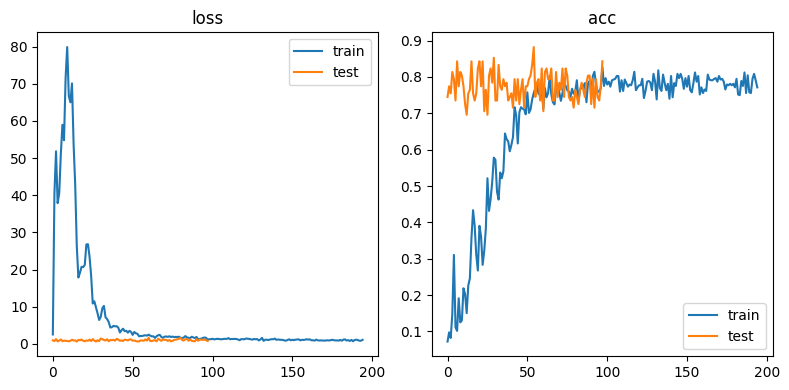

In [13]:
''' print the accuracy and plot loss and accuracy graphs '''

# Print the accuracy of the trained model on the test set.
print("Model accuracy (average) on test set:", \
            torch.mean(torch.tensor(testacc)), '\n')

# Plot loss and accuracy graphs.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

ax1.plot(trainloss[:-1])
ax1.plot(testloss[:-1])
ax1.set_title('loss')
ax1.legend(['train','test'])

ax2.plot(trainacc[:-1])
ax2.plot(testacc[:-1])
ax2.set_title('acc')
_ =ax2.legend(['train','test'])

## Sections 8, 9

In [14]:
''' Find the 10 hardest mistakes of the model. '''

def worst_errors(model, testloader, n_top = 10):
    tops = [] # Final list

    for X, y in tqdm(testloader):
        X = X.float().to(device) # Samples
        y = y.to(device) # Results

        with torch.no_grad():
            y_model = model(X) # Model evaluation
  
        predicted_y = y_model.argmax(dim=1)
        # The indexes of the samples in which there was an error.
        error_idx = (y != predicted_y).nonzero(as_tuple=True)[0]
        if len(error_idx) == 0: # Edge case.
        # If there are no batch errors, go to the next batch.
            continue

        # The sum of the classifications for each sample.
        sum_preds = torch.sum(y_model,dim=1)
       
        # The maximum classification value the model gave to each sample.
        max_preds = torch.max(y_model, dim=1)[0]
        
        # The probability value in each classification (in percentage).
        prob_preds = (max_preds/sum_preds)*100
        
        # Choose only the probabilities of the errors.
        proberros = prob_preds[error_idx]
        if len(error_idx) < n_top: # Edge case.
            # If you are trying to select more values ​​than existing.
            values, indices = proberros.topk(len(error_idx))
        else:
            values, indices = proberros.topk(n_top)
        
        # The images, classifications, probabilities, and truth results
        # of the n most severe errors in the **current batch**.
        img_tops = X[error_idx][indices]
        prd_tops = predicted_y[error_idx][indices]
        prb_tops = prob_preds[error_idx][indices]
        tru_tops = y[error_idx][indices]
        temp_tops = list(zip(img_tops, prd_tops, prb_tops, tru_tops))
        
        # Add the batch results to the final array.
        tops.extend(temp_tops)
        # Sort the array in descending order.
        tops.sort(key=lambda y: y[2], reverse=True)
        # Delete the array except the top n worsts.
        del tops[n_top:]

    return tops

n_top = 10
top_worsts = worst_errors(resnet18,testloader,n_top)

100%|██████████| 99/99 [00:22<00:00,  4.37it/s]


Estimated class: car w.p 14.10%
Real class: truck


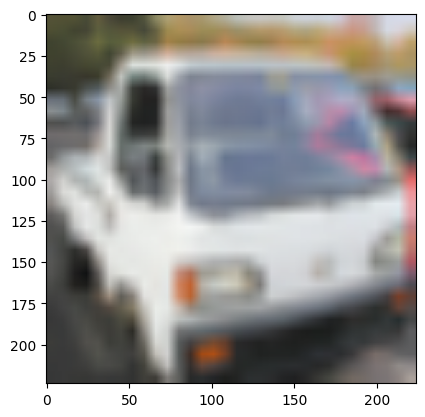



Estimated class: car w.p 13.92%
Real class: truck


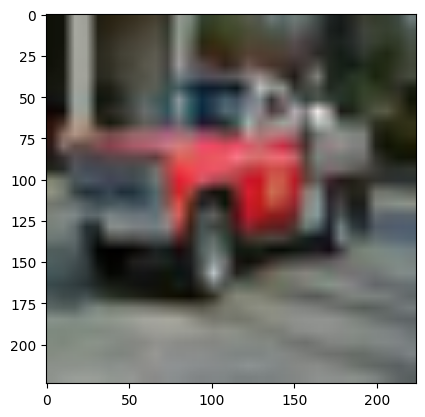



Estimated class: truck w.p 13.77%
Real class: car


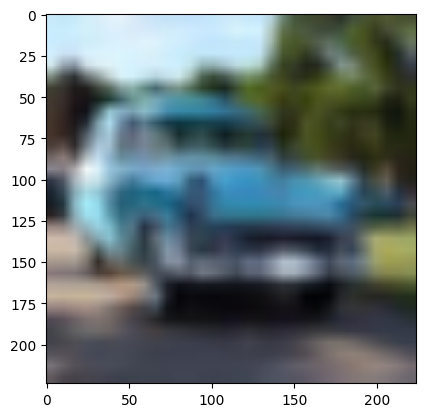



Estimated class: car w.p 13.71%
Real class: truck


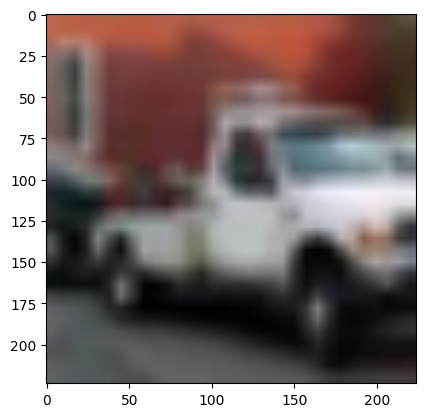



Estimated class: car w.p 13.66%
Real class: truck


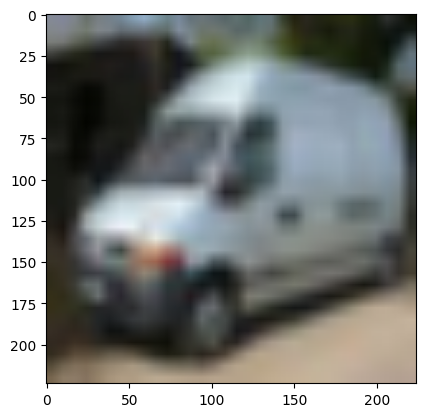



Estimated class: car w.p 13.64%
Real class: truck


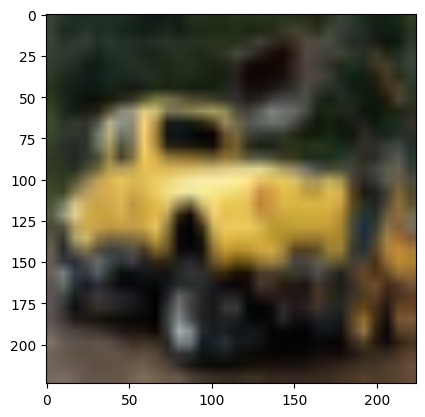



Estimated class: car w.p 13.46%
Real class: truck


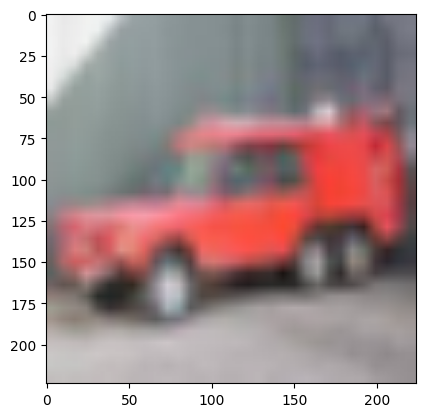



Estimated class: car w.p 13.39%
Real class: truck


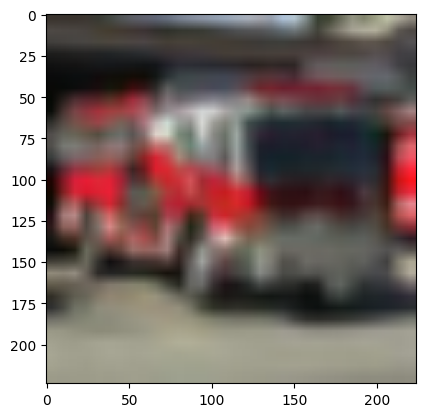



Estimated class: car w.p 13.28%
Real class: truck


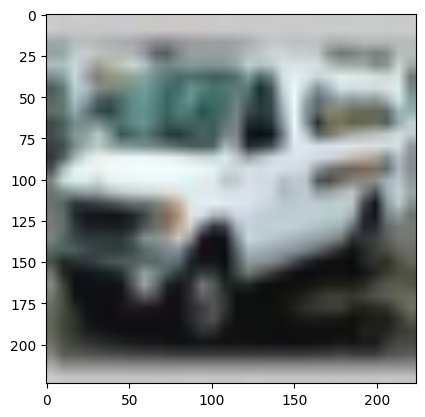



Estimated class: car w.p 13.27%
Real class: truck


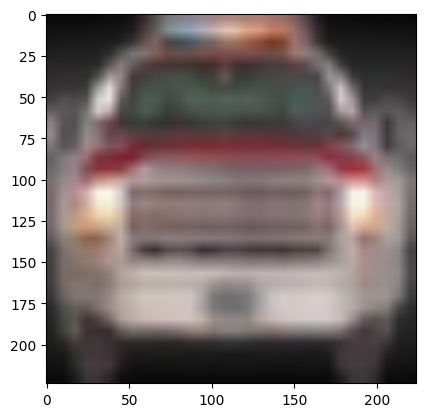

In [15]:
''' Print the results '''

# Denormalize the images so they return to the original properties.
invTrans = transforms.Compose([
                    transforms.Normalize(mean = [ 0., 0., 0. ],
                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                        std = [ 1., 1., 1. ])])

for i in range(n_top):
    # Preprocessing the image.
    img = invTrans(top_worsts[i][0].cpu().detach())
    npimg = torchvision.utils.make_grid(img).numpy()
    # Display the data as an image.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # Prints
    print(f"Estimated class: {classes[top_worsts[i][1]]} " +
                            f"w.p {top_worsts[i][2]:.2f}%")
    print(f"Real class: {classes[top_worsts[i][3]]}")
    plt.show()
    print('\n')

## Sections 10, 11

In [16]:
# Residual block that reduces the dimensions of length and width.
# Copied from the learning guide. 

class ResBlockDownSamp(nn.Module):
    def __init__(self, in_channels, use_bias=False, rate=2):
        super().__init__()
        out_channels=in_channels*rate
        self.relu=nn.ReLU()
        
        self.conv1=nn.Conv2d(in_channels,out_channels,3,
                             padding=1,stride=2,bias=use_bias)
        self.bn1=nn.BatchNorm2d(out_channels)

        self.conv2=nn.Conv2d(out_channels,out_channels,3,
                             padding="same",bias=use_bias)
        self.bn2=nn.BatchNorm2d(out_channels)
        
        self.downsampX=nn.Conv2d(in_channels,out_channels,1
                                 ,stride=2,bias=use_bias)
    def forward(self, X):
        Y1  = self.conv1(X)
        Y1  = self.bn1(Y1)
        Y1  = self.relu(Y1)
        Y1  = self.conv2(Y1)
        Y1  = self.bn2(Y1)
        Y2  = Y1 + self.downsampX(X)
        Y   = self.relu(Y2)
        return Y

In [17]:
# The new model.
import math
class Net(nn.Module):
    def __init__(self, in_channels, dropout=0.5, use_bias=False):
        super().__init__()
        # 3 Residual blocks.
        rates = [4,2,2]
        self.block1 = ResBlockDownSamp(in_channels, rate=rates[0], use_bias=use_bias)
        self.block2 = ResBlockDownSamp(in_channels*rates[0], rate=rates[1], use_bias=use_bias)
        self.block3 = ResBlockDownSamp(in_channels*rates[0]*rates[2], rate=rates[2], use_bias=use_bias)
        # Adaptive average pooling layer.
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        # Classifier
        self.fc = nn.Linear(in_channels*math.prod(rates),10)

    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.avgpool(x)
        x = self.fc(x.flatten(start_dim=1))
        return x

In [18]:
''' Initialize the new model. '''

# Insert the number of channels of the samples in the data set to the model.
batch = next(iter(trainloader))
model = Net(batch[0].shape[1], use_bias=True).to(device)

# Set loss function and optimizer.
CE_loss = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model.parameters(), lr=0.1)

In [19]:
''' Train and test the model '''
from numpy.core.fromnumeric import mean

EPOCHS = 40
trainloss2, trainacc2, testloss2, testacc2 = [], [], [], []
for i in range(EPOCHS):
    print(f"Epoch {i+1} train:")
    tr_l, tr_a = train_epoch(model, trainloader, optimizer2, CE_loss)
    
    print("Train accuracy:", mean(tr_a))
    trainloss2.extend(tr_l), trainacc2.extend(tr_a)
    
    print(f"Epoch {i+1} test:")
    te_l, te_a = test(model, testloader, CE_loss) 
    testloss2.extend(te_l), testacc2.extend(te_a)

Epoch 1 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.21210481
Epoch 1 test:


100%|██████████| 99/99 [00:21<00:00,  4.60it/s]


Epoch 2 train:


100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Train accuracy: 0.27286616
Epoch 2 test:


100%|██████████| 99/99 [00:20<00:00,  4.72it/s]


Epoch 3 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.31925622
Epoch 3 test:


100%|██████████| 99/99 [00:21<00:00,  4.59it/s]


Epoch 4 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.36216328
Epoch 4 test:


100%|██████████| 99/99 [00:21<00:00,  4.65it/s]


Epoch 5 train:


100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Train accuracy: 0.40309918
Epoch 5 test:


100%|██████████| 99/99 [00:21<00:00,  4.64it/s]


Epoch 6 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.4338405
Epoch 6 test:


100%|██████████| 99/99 [00:20<00:00,  4.78it/s]


Epoch 7 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.46255276
Epoch 7 test:


100%|██████████| 99/99 [00:21<00:00,  4.60it/s]


Epoch 8 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.4890462
Epoch 8 test:


100%|██████████| 99/99 [00:20<00:00,  4.74it/s]


Epoch 9 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.50667554
Epoch 9 test:


100%|██████████| 99/99 [00:21<00:00,  4.58it/s]


Epoch 10 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.5145412
Epoch 10 test:


100%|██████████| 99/99 [00:21<00:00,  4.58it/s]


Epoch 11 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.52852345
Epoch 11 test:


100%|██████████| 99/99 [00:21<00:00,  4.59it/s]


Epoch 12 train:


100%|██████████| 98/98 [01:26<00:00,  1.14it/s]


Train accuracy: 0.53489333
Epoch 12 test:


100%|██████████| 99/99 [00:20<00:00,  4.80it/s]


Epoch 13 train:


100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Train accuracy: 0.5450177
Epoch 13 test:


100%|██████████| 99/99 [00:21<00:00,  4.70it/s]


Epoch 14 train:


100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Train accuracy: 0.5474492
Epoch 14 test:


100%|██████████| 99/99 [00:20<00:00,  4.77it/s]


Epoch 15 train:


100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Train accuracy: 0.5551772
Epoch 15 test:


100%|██████████| 99/99 [00:21<00:00,  4.67it/s]


Epoch 16 train:


100%|██████████| 98/98 [01:24<00:00,  1.15it/s]


Train accuracy: 0.56424814
Epoch 16 test:


100%|██████████| 99/99 [00:21<00:00,  4.53it/s]


Epoch 17 train:


100%|██████████| 98/98 [01:27<00:00,  1.11it/s]


Train accuracy: 0.5612909
Epoch 17 test:


100%|██████████| 99/99 [00:21<00:00,  4.69it/s]


Epoch 18 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.5695343
Epoch 18 test:


100%|██████████| 99/99 [00:21<00:00,  4.60it/s]


Epoch 19 train:


100%|██████████| 98/98 [01:26<00:00,  1.14it/s]


Train accuracy: 0.564493
Epoch 19 test:


100%|██████████| 99/99 [00:20<00:00,  4.83it/s]


Epoch 20 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.5745386
Epoch 20 test:


100%|██████████| 99/99 [00:21<00:00,  4.63it/s]


Epoch 21 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.57008094
Epoch 21 test:


100%|██████████| 99/99 [00:20<00:00,  4.77it/s]


Epoch 22 train:


100%|██████████| 98/98 [01:28<00:00,  1.11it/s]


Train accuracy: 0.582762
Epoch 22 test:


100%|██████████| 99/99 [00:21<00:00,  4.61it/s]


Epoch 23 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.58635604
Epoch 23 test:


100%|██████████| 99/99 [00:20<00:00,  4.83it/s]


Epoch 24 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.59099686
Epoch 24 test:


100%|██████████| 99/99 [00:21<00:00,  4.61it/s]


Epoch 25 train:


100%|██████████| 98/98 [01:26<00:00,  1.14it/s]


Train accuracy: 0.59014934
Epoch 25 test:


100%|██████████| 99/99 [00:20<00:00,  4.82it/s]


Epoch 26 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.59421027
Epoch 26 test:


100%|██████████| 99/99 [00:21<00:00,  4.62it/s]


Epoch 27 train:


100%|██████████| 98/98 [01:25<00:00,  1.15it/s]


Train accuracy: 0.5937937
Epoch 27 test:


100%|██████████| 99/99 [00:21<00:00,  4.65it/s]


Epoch 28 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.59680307
Epoch 28 test:


100%|██████████| 99/99 [00:20<00:00,  4.76it/s]


Epoch 29 train:


100%|██████████| 98/98 [01:24<00:00,  1.16it/s]


Train accuracy: 0.6041097
Epoch 29 test:


100%|██████████| 99/99 [00:21<00:00,  4.60it/s]


Epoch 30 train:


100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Train accuracy: 0.60133094
Epoch 30 test:


100%|██████████| 99/99 [00:20<00:00,  4.72it/s]


Epoch 31 train:


100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Train accuracy: 0.60471237
Epoch 31 test:


100%|██████████| 99/99 [00:21<00:00,  4.67it/s]


Epoch 32 train:


100%|██████████| 98/98 [01:25<00:00,  1.14it/s]


Train accuracy: 0.60669774
Epoch 32 test:


100%|██████████| 99/99 [00:21<00:00,  4.58it/s]


Epoch 33 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.611982
Epoch 33 test:


100%|██████████| 99/99 [00:21<00:00,  4.63it/s]


Epoch 34 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.61099595
Epoch 34 test:


100%|██████████| 99/99 [00:21<00:00,  4.65it/s]


Epoch 35 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.60980964
Epoch 35 test:


100%|██████████| 99/99 [00:20<00:00,  4.80it/s]


Epoch 36 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.6148054
Epoch 36 test:


100%|██████████| 99/99 [00:21<00:00,  4.59it/s]


Epoch 37 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.61749786
Epoch 37 test:


100%|██████████| 99/99 [00:20<00:00,  4.82it/s]


Epoch 38 train:


100%|██████████| 98/98 [01:27<00:00,  1.12it/s]


Train accuracy: 0.6160933
Epoch 38 test:


100%|██████████| 99/99 [00:21<00:00,  4.65it/s]


Epoch 39 train:


100%|██████████| 98/98 [01:26<00:00,  1.13it/s]


Train accuracy: 0.6151195
Epoch 39 test:


100%|██████████| 99/99 [00:20<00:00,  4.76it/s]


Epoch 40 train:


100%|██████████| 98/98 [01:27<00:00,  1.13it/s]


Train accuracy: 0.61978406
Epoch 40 test:


100%|██████████| 99/99 [00:21<00:00,  4.62it/s]


Model accuracy (average) on test set: tensor(0.5290) 



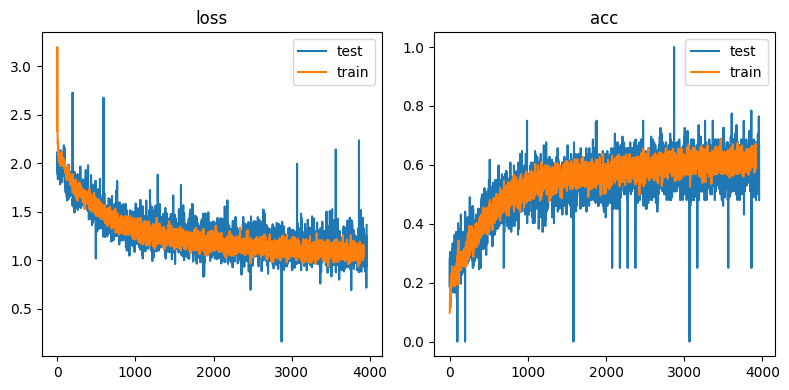

In [20]:
''' print the accuracy and plot loss and accuracy graphs '''

# Print the accuracy of the trained model on the test set.
print("Model accuracy (average) on test set:", \
            torch.mean(torch.tensor(testacc2)), '\n')

# Plot loss and accuracy graphs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)


ax1.plot(testloss2[:-1])
ax1.plot(trainloss2[:-1])
ax1.set_title('loss')
ax1.legend(['test','train'])

ax2.plot(testacc2[:-1])
ax2.plot(trainacc2[:-1])
ax2.set_title('acc')
_ =ax2.legend(['test','train'])

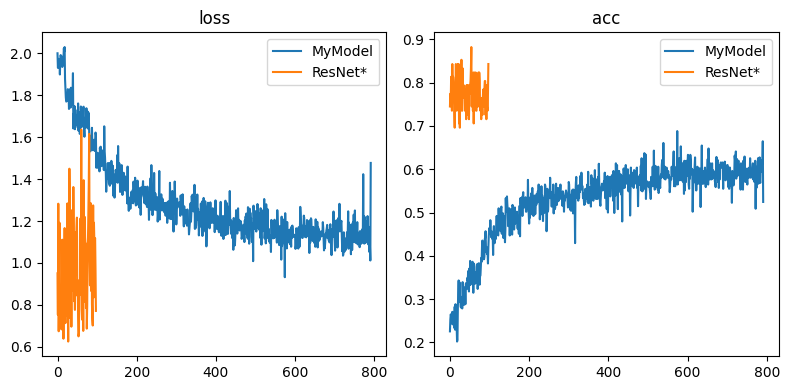

In [21]:
''' Compare to ResNet '''

# Because ResNet* ran about 100 batches, and the new model ran about 500,
# so we'll normalize the data. We will take an average of every 5 samples.
modelacc = torch.mean(torch.tensor(testacc2).reshape(-1,5),dim=1)
modeloss = torch.mean(torch.tensor(testloss2).reshape(-1,5),dim=1)

''' plot loss and accuracy graphs '''
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

ax1.plot(modeloss)
ax1.plot(testloss[:-1])
ax1.set_title('loss')
ax1.legend(['MyModel','ResNet*'])

ax2.plot(modelacc)
ax2.plot(testacc[:-1])
ax2.set_title('acc')
_ =ax2.legend(['MyModel','ResNet*'])

According to the comparison,  
ResNet* accuracy is much better than MyModel.  
Therefore, we would like to choose it from the two.